# 1. Setup
Import the necessary libraries and set up the necessary helper functions

In [14]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.7.1
torchvision version: 0.22.1


In [15]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [16]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [17]:
def set_seeds(seed: int=42):
    """
    Set the random seed for torch operations

    Args:
        seed (int) -> random seed to set. Defaults to 42
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)

# 2. Create the Datasets and Dataloaders
We're going to use the food pictures that we've been using in the previous notebooks. We don't need to download the data because it's already in this folder. 
\
\
So now we're going to create the datasets and dataloaders based on the specifications of the pre-trained model that we will be using

In [18]:
from pathlib import Path
from scripts import data_setup

# Setup the directories
image_path = Path("../data/pizza_steak_sushi")
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup the ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]   
)

# Manually create the transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

# Create the dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x3c3856750>,
 ['pizza', 'steak', 'sushi'])

# 3. Setting up the pretrained model
Now that we have the data all setup, we can start to freeze the model in a way that we like before we actually train and test it on the data

In [19]:
# Download the pretrained weights from the model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model using those pretrained weights
model = torchvision.models.efficientnet_b0(weights=weights)

In [20]:
# Freeze all of the convolutional feature extraction layers
# By setting requires_grad to be false
for param in model.features.parameters():
    param.requires_grad = False

# Set the seeds
set_seeds()

# Update the classifier layer to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True)
)

In [21]:
from torchinfo import summary

# Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 4. Train the model
Now that we have the data and the model all setup, we want to actually train the model on that data and track how well it does. 

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Now we're going to use torch's SummaryWriter() function to save specific details about our model so that we don't have to manually output them in a python dictionary.

In [23]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter


# Create a writer with all default settings
writer = SummaryWriter()

In [24]:
from scripts.engine import train

set_seeds()

# Send the model to the device
model = model.to(device)

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device,
                writer=writer)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0834 | train_acc: 0.3906 | test_loss: 0.9157 | test_acc: 0.5085


 20%|██        | 1/5 [00:03<00:15,  3.76s/it]

Epoch: 2 | train_loss: 0.9435 | train_acc: 0.6016 | test_loss: 0.8158 | test_acc: 0.7339


 40%|████      | 2/5 [00:06<00:10,  3.43s/it]

Epoch: 3 | train_loss: 0.7821 | train_acc: 0.7383 | test_loss: 0.6821 | test_acc: 0.9176


 60%|██████    | 3/5 [00:10<00:06,  3.32s/it]

Epoch: 4 | train_loss: 0.6857 | train_acc: 0.8477 | test_loss: 0.6748 | test_acc: 0.8059


 80%|████████  | 4/5 [00:13<00:03,  3.24s/it]

Epoch: 5 | train_loss: 0.7360 | train_acc: 0.7031 | test_loss: 0.6787 | test_acc: 0.7955


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


Use this command to launch the tensorboard GUI: tensorboard --logdir=./

# 6. Create helper to build SummaryWriter() instances
We want to track things such as:
- Experiment date/timestamp - when did the experiment take place?
- Experiment name - is there something we'd like to call the experiment?
- Model name - what model was used?
- Extra - should anything else be tracked?
\
\
This function will produce a SummaryWriter() instance to a custom log_dir. Somthing like **runs/YYYY-MM-DD/experiment_name/model_name/extra**

In [25]:
def create_writer(
        experiment_name: str,
        model_name: str,
        extra: str=None
):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [26]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnet0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2025-07-29/data_10_percent/effnet0/5_epochs...


# 7. Running experiments
Different experiments that we can run
- Change the number of epochs.
- Change the number of layers/hidden units.
- Change the amount of data.
- Change the learning rate.
- Try different kinds of data augmentation.
- Choose a different model architecture.

First we need to set up the data that we will be using in the experiments

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("../data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

In [28]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [29]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [30]:
BATCH_SIZE = 32

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


Next we need to build the feature extractors for our models that we will be using in the experiments as well

In [32]:
OUT_FEATURES = len(class_names)

# Create an EffNetB0 model
def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Set the seeds
    set_seeds()

    # Change the classifier
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create EffnetB2 model
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

Set up the experiment training code

In [33]:
num_epochs = [5, 10]

models = ["effnetb0", "effnetb2"]

train_dataloaders = {
    "data_10_percent": train_dataloader_10_percent,
    "data_20_percent": train_dataloader_20_percent
}

In [ ]:
from scripts.utils import save_model

set_seeds(seed=42)

experiment_number = 0

# Loop through each of the dataloaders
for dataloader_name, train_dataloader in train_dataloaders.items():

    # Loop through each number of epochs
    for epochs in num_epochs:

        # Loop through each model name and create a new model based on the name
        for model_name in models:

            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}") 

            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(
                model=model,
                target_dir="models",
                model_name=save_filepath
            )
            print("-"*50 + "\n")


[INFO] Experiment number: 2
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-29/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0624 | train_acc: 0.4648 | test_loss: 0.9344 | test_acc: 0.4574


 20%|██        | 1/5 [00:03<00:13,  3.47s/it]

Epoch: 2 | train_loss: 0.9364 | train_acc: 0.5781 | test_loss: 0.8267 | test_acc: 0.6108


 40%|████      | 2/5 [00:07<00:10,  3.57s/it]

Epoch: 3 | train_loss: 0.8002 | train_acc: 0.6914 | test_loss: 0.7180 | test_acc: 0.8352


 60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

Epoch: 4 | train_loss: 0.7128 | train_acc: 0.7773 | test_loss: 0.6182 | test_acc: 0.8968


 80%|████████  | 4/5 [00:13<00:03,  3.47s/it]

Epoch: 5 | train_loss: 0.6097 | train_acc: 0.8906 | test_loss: 0.5751 | test_acc: 0.8968


100%|██████████| 5/5 [00:17<00:00,  3.44s/it]


[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-29/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0818 | train_acc: 0.3594 | test_loss: 0.9402 | test_acc: 0.7320


 20%|██        | 1/5 [00:06<00:25,  6.42s/it]

Epoch: 2 | train_loss: 0.8891 | train_acc: 0.7500 | test_loss: 0.8897 | test_acc: 0.7330


 40%|████      | 2/5 [00:11<00:16,  5.44s/it]

Epoch: 3 | train_loss: 0.8643 | train_acc: 0.6641 | test_loss: 0.8083 | test_acc: 0.7746


 60%|██████    | 3/5 [00:15<00:10,  5.02s/it]

Epoch: 4 | train_loss: 0.7291 | train_acc: 0.8516 | test_loss: 0.6937 | test_acc: 0.9072


 80%|████████  | 4/5 [00:20<00:04,  4.81s/it]

Epoch: 5 | train_loss: 0.7012 | train_acc: 0.7617 | test_loss: 0.6384 | test_acc: 0.9167


100%|██████████| 5/5 [00:24<00:00,  4.97s/it]


[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-29/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0624 | train_acc: 0.4648 | test_loss: 0.9344 | test_acc: 0.4574


 10%|█         | 1/10 [00:03<00:28,  3.16s/it]

Epoch: 2 | train_loss: 0.9364 | train_acc: 0.5781 | test_loss: 0.8267 | test_acc: 0.6108


 20%|██        | 2/10 [00:06<00:26,  3.32s/it]

Epoch: 3 | train_loss: 0.8002 | train_acc: 0.6914 | test_loss: 0.7180 | test_acc: 0.8352


 30%|███       | 3/10 [00:09<00:22,  3.26s/it]

Epoch: 4 | train_loss: 0.7128 | train_acc: 0.7773 | test_loss: 0.6182 | test_acc: 0.8968


 40%|████      | 4/10 [00:13<00:19,  3.29s/it]

Epoch: 5 | train_loss: 0.6097 | train_acc: 0.8906 | test_loss: 0.5751 | test_acc: 0.8968


 50%|█████     | 5/10 [00:16<00:16,  3.26s/it]

Epoch: 6 | train_loss: 0.5558 | train_acc: 0.8828 | test_loss: 0.5908 | test_acc: 0.8561


 60%|██████    | 6/10 [00:19<00:12,  3.24s/it]

Epoch: 7 | train_loss: 0.6372 | train_acc: 0.7109 | test_loss: 0.5933 | test_acc: 0.8362


 70%|███████   | 7/10 [00:22<00:09,  3.22s/it]

Epoch: 8 | train_loss: 0.4921 | train_acc: 0.9375 | test_loss: 0.5318 | test_acc: 0.8968


 80%|████████  | 8/10 [00:25<00:06,  3.24s/it]

Epoch: 9 | train_loss: 0.4642 | train_acc: 0.9258 | test_loss: 0.5143 | test_acc: 0.8968


 90%|█████████ | 9/10 [00:29<00:03,  3.24s/it]

Epoch: 10 | train_loss: 0.5918 | train_acc: 0.7812 | test_loss: 0.4719 | test_acc: 0.8864


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-29/data_10_percent/effnetb2/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0818 | train_acc: 0.3594 | test_loss: 0.9402 | test_acc: 0.7320


 10%|█         | 1/10 [00:04<00:43,  4.80s/it]

Epoch: 2 | train_loss: 0.8891 | train_acc: 0.7500 | test_loss: 0.8897 | test_acc: 0.7330


 20%|██        | 2/10 [00:09<00:37,  4.68s/it]

Epoch: 3 | train_loss: 0.8643 | train_acc: 0.6641 | test_loss: 0.8083 | test_acc: 0.7746


 30%|███       | 3/10 [00:13<00:32,  4.59s/it]

Epoch: 4 | train_loss: 0.7291 | train_acc: 0.8516 | test_loss: 0.6937 | test_acc: 0.9072


 40%|████      | 4/10 [00:18<00:27,  4.56s/it]

Epoch: 5 | train_loss: 0.7012 | train_acc: 0.7617 | test_loss: 0.6384 | test_acc: 0.9167


 50%|█████     | 5/10 [00:23<00:23,  4.69s/it]

Epoch: 6 | train_loss: 0.6193 | train_acc: 0.7891 | test_loss: 0.6405 | test_acc: 0.8968


 60%|██████    | 6/10 [00:27<00:18,  4.66s/it]

Epoch: 7 | train_loss: 0.6161 | train_acc: 0.8164 | test_loss: 0.5852 | test_acc: 0.9176


 70%|███████   | 7/10 [00:32<00:13,  4.64s/it]

Epoch: 8 | train_loss: 0.5418 | train_acc: 0.8086 | test_loss: 0.5970 | test_acc: 0.8769


 80%|████████  | 8/10 [00:37<00:09,  4.61s/it]

Epoch: 9 | train_loss: 0.5002 | train_acc: 0.9062 | test_loss: 0.5477 | test_acc: 0.9176


 90%|█████████ | 9/10 [00:41<00:04,  4.59s/it]

Epoch: 10 | train_loss: 0.5353 | train_acc: 0.8086 | test_loss: 0.5330 | test_acc: 0.9280


100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 10
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-29/data_20_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9505 | train_acc: 0.6167 | test_loss: 0.6602 | test_acc: 0.8655


 20%|██        | 1/5 [00:06<00:26,  6.66s/it]

Epoch: 2 | train_loss: 0.6958 | train_acc: 0.8021 | test_loss: 0.5821 | test_acc: 0.9176


 40%|████      | 2/5 [00:12<00:18,  6.12s/it]

Epoch: 3 | train_loss: 0.5850 | train_acc: 0.8458 | test_loss: 0.5025 | test_acc: 0.8977


 60%|██████    | 3/5 [00:17<00:11,  5.83s/it]

Epoch: 4 | train_loss: 0.4662 | train_acc: 0.8729 | test_loss: 0.4115 | test_acc: 0.9280


 80%|████████  | 4/5 [00:22<00:05,  5.45s/it]

Epoch: 5 | train_loss: 0.4542 | train_acc: 0.8542 | test_loss: 0.3878 | test_acc: 0.9280


100%|██████████| 5/5 [00:27<00:00,  5.47s/it]


[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 12
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-29/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9844 | train_acc: 0.5292 | test_loss: 0.7837 | test_acc: 0.8153


 20%|██        | 1/5 [00:07<00:28,  7.12s/it]

Epoch: 2 | train_loss: 0.7310 | train_acc: 0.7917 | test_loss: 0.6702 | test_acc: 0.8864


 40%|████      | 2/5 [00:14<00:21,  7.11s/it]

Epoch: 3 | train_loss: 0.5796 | train_acc: 0.8688 | test_loss: 0.5646 | test_acc: 0.9176


 60%|██████    | 3/5 [00:20<00:13,  6.75s/it]

Epoch: 4 | train_loss: 0.5178 | train_acc: 0.8542 | test_loss: 0.5142 | test_acc: 0.9176


 80%|████████  | 4/5 [00:26<00:06,  6.61s/it]

Epoch: 5 | train_loss: 0.4715 | train_acc: 0.8729 | test_loss: 0.4456 | test_acc: 0.9489


100%|██████████| 5/5 [00:33<00:00,  6.68s/it]


[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 14
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-29/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9505 | train_acc: 0.6167 | test_loss: 0.6602 | test_acc: 0.8655


 10%|█         | 1/10 [00:04<00:41,  4.56s/it]

Epoch: 2 | train_loss: 0.6958 | train_acc: 0.8021 | test_loss: 0.5821 | test_acc: 0.9176


 20%|██        | 2/10 [00:09<00:36,  4.56s/it]

Epoch: 3 | train_loss: 0.5850 | train_acc: 0.8458 | test_loss: 0.5025 | test_acc: 0.8977


 30%|███       | 3/10 [00:13<00:32,  4.61s/it]

Epoch: 4 | train_loss: 0.4662 | train_acc: 0.8729 | test_loss: 0.4115 | test_acc: 0.9280


 40%|████      | 4/10 [00:19<00:29,  4.99s/it]

Epoch: 5 | train_loss: 0.4542 | train_acc: 0.8542 | test_loss: 0.3878 | test_acc: 0.9280


 50%|█████     | 5/10 [00:24<00:24,  4.93s/it]

Epoch: 6 | train_loss: 0.4245 | train_acc: 0.8521 | test_loss: 0.3722 | test_acc: 0.9176


 60%|██████    | 6/10 [00:29<00:19,  4.90s/it]

Epoch: 7 | train_loss: 0.3971 | train_acc: 0.8750 | test_loss: 0.3271 | test_acc: 0.9176


 70%|███████   | 7/10 [00:33<00:14,  4.76s/it]

Epoch: 8 | train_loss: 0.3512 | train_acc: 0.9000 | test_loss: 0.3340 | test_acc: 0.9280


 80%|████████  | 8/10 [00:38<00:09,  4.69s/it]

Epoch: 9 | train_loss: 0.3547 | train_acc: 0.8750 | test_loss: 0.3331 | test_acc: 0.9280


 90%|█████████ | 9/10 [00:42<00:04,  4.64s/it]

Epoch: 10 | train_loss: 0.3867 | train_acc: 0.8917 | test_loss: 0.2698 | test_acc: 0.9176


100%|██████████| 10/10 [00:47<00:00,  4.71s/it]


[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 16
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-29/data_20_percent/effnetb2/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9844 | train_acc: 0.5292 | test_loss: 0.7837 | test_acc: 0.8153


 10%|█         | 1/10 [00:06<00:57,  6.36s/it]

Epoch: 2 | train_loss: 0.7310 | train_acc: 0.7917 | test_loss: 0.6702 | test_acc: 0.8864


 20%|██        | 2/10 [00:13<00:52,  6.58s/it]

Epoch: 3 | train_loss: 0.5796 | train_acc: 0.8688 | test_loss: 0.5646 | test_acc: 0.9176


 30%|███       | 3/10 [00:19<00:45,  6.48s/it]

Epoch: 4 | train_loss: 0.5178 | train_acc: 0.8542 | test_loss: 0.5142 | test_acc: 0.9176


 40%|████      | 4/10 [00:25<00:38,  6.42s/it]

Epoch: 5 | train_loss: 0.4715 | train_acc: 0.8729 | test_loss: 0.4456 | test_acc: 0.9489


 50%|█████     | 5/10 [00:32<00:32,  6.40s/it]

Epoch: 6 | train_loss: 0.3704 | train_acc: 0.9146 | test_loss: 0.4711 | test_acc: 0.9280


 60%|██████    | 6/10 [00:38<00:25,  6.42s/it]

Epoch: 7 | train_loss: 0.3606 | train_acc: 0.9313 | test_loss: 0.4126 | test_acc: 0.9384


 70%|███████   | 7/10 [00:45<00:19,  6.46s/it]

Epoch: 8 | train_loss: 0.3210 | train_acc: 0.9292 | test_loss: 0.4114 | test_acc: 0.9280


 80%|████████  | 8/10 [00:52<00:13,  6.87s/it]

Epoch: 9 | train_loss: 0.3619 | train_acc: 0.8917 | test_loss: 0.4370 | test_acc: 0.8371


 90%|█████████ | 9/10 [00:59<00:06,  6.74s/it]

Epoch: 10 | train_loss: 0.3275 | train_acc: 0.8917 | test_loss: 0.3781 | test_acc: 0.9489


100%|██████████| 10/10 [01:06<00:00,  6.61s/it]


[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------



# 9. Load the best model
Looking at the logs it seems that the eighth model was the best (highest test accuracy and second lowest test loss)
\
\
This it the EffNetB2 with the 20% data and 10 epochs. In essence, our biggest model achieved the best results. 

In [ ]:
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of effnetb2
best_model = create_effnetb2()

# Load the saved model's parameters into the current model's state dict
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.
EfficientNetB2 feature extractor model size: 29 MB


In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

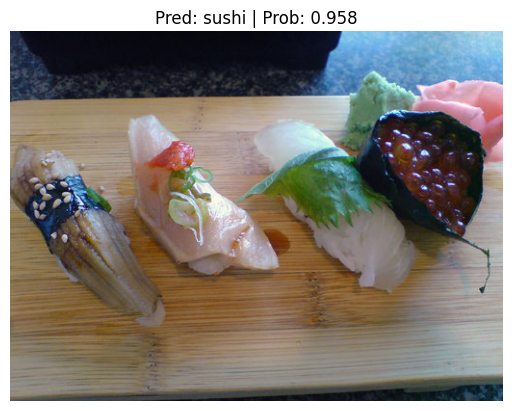

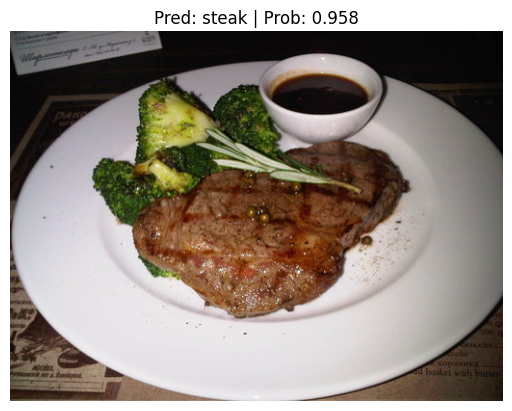

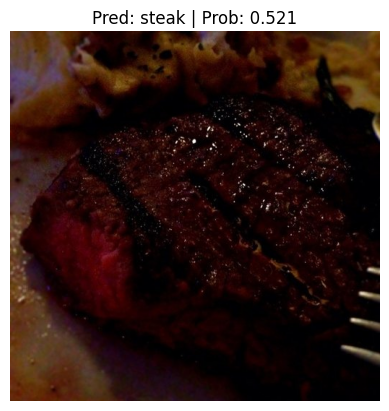

In [40]:
# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))